In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import yfinance as yf
import seaborn as sns
from scipy import signal
from statsmodels.tsa.stattools import adfuller

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_excel('data/Source Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')
#display(data)

spy_data = data[['Date', 'Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread']].dropna()
spy_data.set_index('Date', inplace=True)

#Transaform GDP variable into real terms
spy_data['GDP'] = spy_data['GDP'] / spy_data['PCEPI']

display(spy_data)

,Futures Shock,SPX Shock,1Y Treasury,SPX Total,GDP,PCEPI,Credit Spread
Date,,,,,,,
1992-01-01,0.000000,0.00000,4.03,408.8,100.828970,62.638,2.10
1992-02-01,0.004572,0.03621,4.06,412.7,101.223052,62.797,1.89
1992-03-01,0.000000,0.00000,3.98,403.7,101.940889,62.949,1.71
1992-04-01,-0.258935,0.61127,3.73,414.9,102.081101,63.119,1.73
1992-05-01,0.012382,-0.04802,3.82,415.4,101.795959,63.203,1.74
...,...,...,...,...,...,...,...
2023-09-01,0.051324,-0.17053,5.33,4288.1,229.449710,121.267,1.78
2023-10-01,0.000000,0.00000,5.33,4193.8,228.610941,121.309,1.83
2023-11-01,-0.013891,0.01259,5.33,4567.8,230.418379,121.296,1.79


[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'S&P 500 Price')

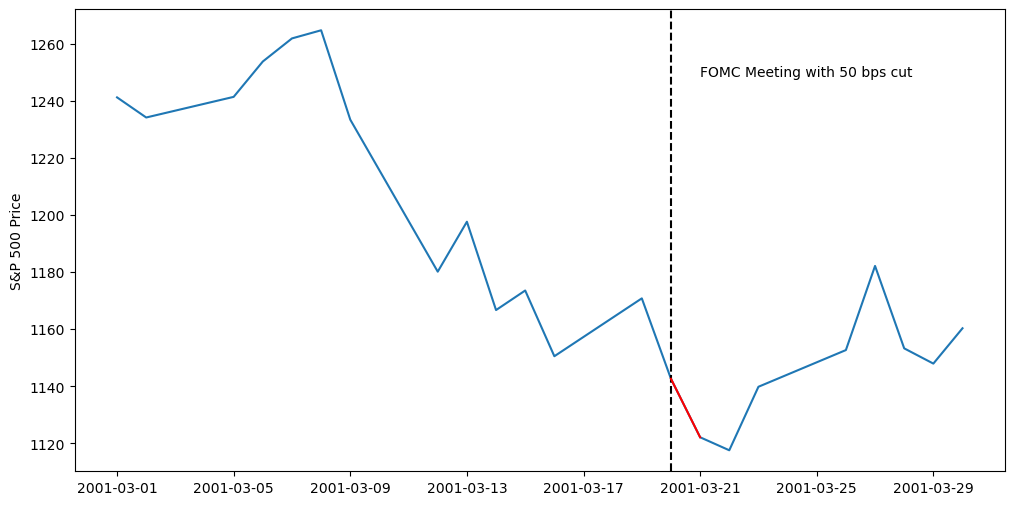

In [3]:
# Use yfinance to download the S&P 500 index between 15 Feb 2001 and 15 March 2001

start_date = '2001-03-01'
end_date = '2001-03-31'
spx = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']

plt.figure(figsize=(12, 6))
plt.plot(spx)

# Find the next trading day after 3 March 2001
fomc_date = pd.Timestamp('2001-03-20')

# Add a black vertical line at the date of the FOMC meeting
plt.axvline(x=fomc_date, color='black', linestyle='--')

#label the dotted line as the FOMC meeting with rate cut, move the label a few pixels to the right
plt.text(pd.Timestamp('2001-03-21'), 1250, 'FOMC Meeting with 50 bps cut',verticalalignment='center')

#plot a red line for the price change on the fomc meeting day and the following day
signal = spx.loc[[fomc_date, fomc_date + pd.Timedelta(days=1)]]  # Select the price on the FOMC meeting day and the following day
plt.plot(signal.index, signal, color='red')

#label y axis S&P 500 Price
plt.ylabel('S&P 500 Price')

Text(0.15, -1.5, 'IV: 78')

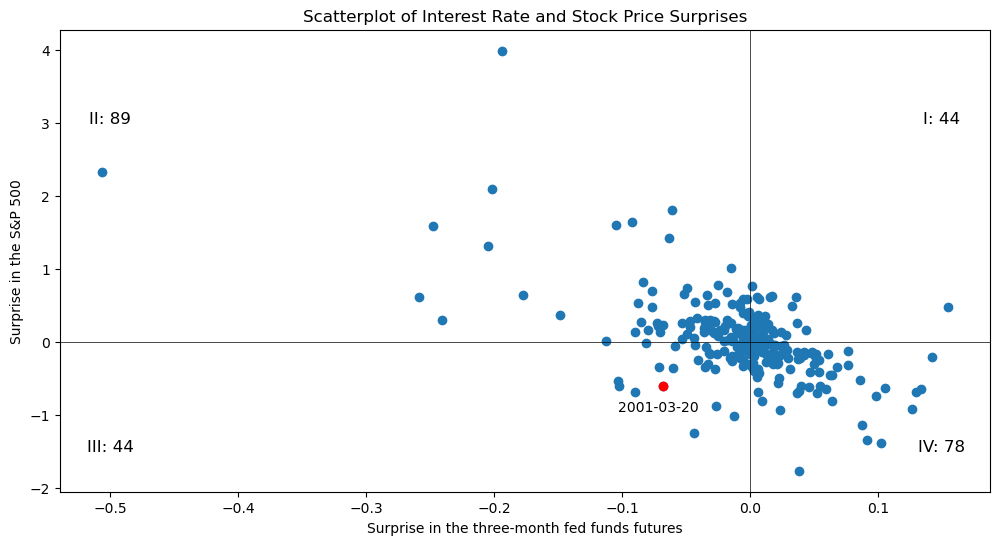

In [4]:
shocks = spy_data[['Futures Shock', 'SPX Shock']]

#Create scatter plot of the shocks
plt.figure(figsize=(12, 6))
plt.scatter(shocks['Futures Shock'], shocks['SPX Shock'])
plt.xlabel('Surprise in the three-month fed funds futures')
plt.ylabel('Surprise in the S&P 500')
plt.title('Scatterplot of Interest Rate and Stock Price Surprises')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

#Make the scatter plot of the shocks with the FOMC meeting day in red
fomc_date = pd.Timestamp('2001-03-01')
signal = shocks.loc[[fomc_date]]
plt.scatter(signal['Futures Shock'], signal['SPX Shock'], color='red')
plt.text(-0.04, -1, '2001-03-20', verticalalignment='bottom', horizontalalignment='right')


#Count the number of observations in each quadrant
quadrants = np.sign(shocks)
quadrants['count'] = 1
quadrants = quadrants.groupby(['Futures Shock', 'SPX Shock']).count().reset_index()
quadrants = quadrants.pivot(index='SPX Shock', columns='Futures Shock', values='count').fillna(0)
quadrants = quadrants.astype(int)

#label each quadrant I, II, III, IV
plt.text(0.15, 3, f'I: {quadrants.loc[1,1]}', fontsize=12, ha='center')
plt.text(-0.5, 3, f'II: {quadrants.loc[1,-1]}', fontsize=12, ha='center')
plt.text(-0.5, -1.5, f'III: {quadrants.loc[-1,-1]}', fontsize=12, ha='center')
plt.text(0.15, -1.5, f'IV: {quadrants.loc[-1,1]}', fontsize=12, ha='center')

In [5]:
# ADF TEST
# List of column names to check for stationarity
columns_to_check = ['Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread']

# Function to run ADF test and print results
def adf_test(series, column_name):
    result = adfuller(series, regression='c')
    print(f'ADF Test for {column_name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')
    print('\n')

# Apply the ADF test to each column
for col in columns_to_check:
    adf_test(spy_data[col], col)

ADF Test for Futures Shock:
ADF Statistic: -6.26718897644418
p-value: 4.0867502239440795e-08
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for SPX Shock:
ADF Statistic: -10.939377958721089
p-value: 9.380401628747977e-20
Critical Values:
    1%: -3.4477686860685
    5%: -2.869216670067509
    10%: -2.570859500573892


ADF Test for 1Y Treasury:
ADF Statistic: -2.526655868973357
p-value: 0.1091226279837903
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for SPX Total:
ADF Statistic: 2.090140345011109
p-value: 0.9987792198527747
Critical Values:
    1%: -3.448343869853195
    5%: -2.869469418606909
    10%: -2.570994248260623


ADF Test for GDP:
ADF Statistic: 0.4883346528802354
p-value: 0.9845141914723283
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for PCEPI:
ADF Statistic: 2.341392830693939
p-

In [6]:
# List of columns to check for stationarity
#columns_to_check = ['Futures Shock', 'M2SL', 'PCEPI', 'FEDFUNDS', 'GDP', 'Unemployment', 'SPX Total']
columns_to_check = ['Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread']

# Function to conduct ADF tests and identify non-stationary variables
def check_stationarity(data, columns_to_check):
    non_stationary_cols = []
    for col in columns_to_check:
        result = adfuller(data[col].dropna(), regression='c')
        if result[1] > 0.05:  # p-value greater than 0.05 indicates non-stationarity
            non_stationary_cols.append(col)
        print(f"{col}: ADF Statistic = {result[0]}, p-value = {result[1]}")
    return non_stationary_cols

## Creating CSV file for MATLAB implementation

1 year treasury is non stationary and can cause problems

In [7]:
VARdata = spy_data.copy()
from scipy import signal
# These Variables in the Paper are in log * 100
for col in ['SPX Total', 'GDP', 'PCEPI']:
    VARdata[col] = np.log(spy_data[col]) * 100

# Apply detrend function to '1Y Treasury' values
#VARdata['1Y Treasury'] = signal.detrend(spy_data['1Y Treasury'].values)

# Create Columns 'year' and 'month' taken from the index
VARdata['year'] = VARdata.index.year
VARdata['month'] = VARdata.index.month

# Place the year and month column as first and second in the df
cols = VARdata.columns.tolist()
cols = cols[-2:] + cols[:-2]
VARdata = VARdata[cols]

#VARdata = VARdata[cols].reset_index(drop=True)

# Rename the columns 
VARdata.columns = ['year', 'month', 'ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']

In [8]:
columns_to_check = ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']
non_stationary_cols = check_stationarity(VARdata, columns_to_check)
print(f"Non-stationary columns: {non_stationary_cols}")

ff4_hf: ADF Statistic = -6.26718897644418, p-value = 4.0867502239440795e-08
sp500_hf: ADF Statistic = -10.939377958721089, p-value = 9.380401628747977e-20
gs1: ADF Statistic = -2.526655868973357, p-value = 0.1091226279837903
logsp500: ADF Statistic = -0.5669306166339858, p-value = 0.878280654429874


us_rgdp: ADF Statistic = -1.4549891546130753, p-value = 0.5556485667120343
us_gdpdef: ADF Statistic = 1.137147552020317, p-value = 0.9955215188741736
ebpnew: ADF Statistic = -3.6159619143239854, p-value = 0.00546310105899709
Non-stationary columns: ['gs1', 'logsp500', 'us_rgdp', 'us_gdpdef']


In [428]:
# Original paper has interest rate as I(0) variable

#Save as a csv file
VARdata.to_csv('data/VARdata.csv', index=False)

In [429]:
#store in a df the min and max values for each column
min_max = pd.DataFrame(index=['min', 'max'], columns=VARdata.columns[2:])
min_max.loc['min'] = VARdata[columns_to_check].min()
min_max.loc['max'] = VARdata[columns_to_check].max()
min_max


#unemp, Unemployment rate\newline(%),0,0,0.15

,ff4_hf,sp500_hf,gs1,logsp500,us_rgdp,us_gdpdef,ebpnew
min,-0.506441,-1.76769,0.05,600.067203,461.342571,413.737212,1.29
max,0.154256,3.99301,6.54,848.582636,544.720945,480.325026,6.01


<Figure size 1200x600 with 0 Axes>

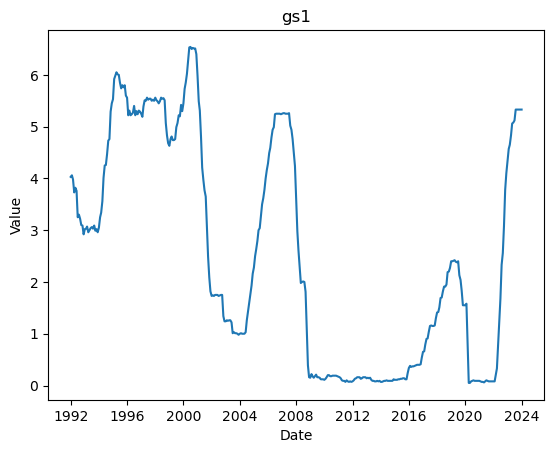

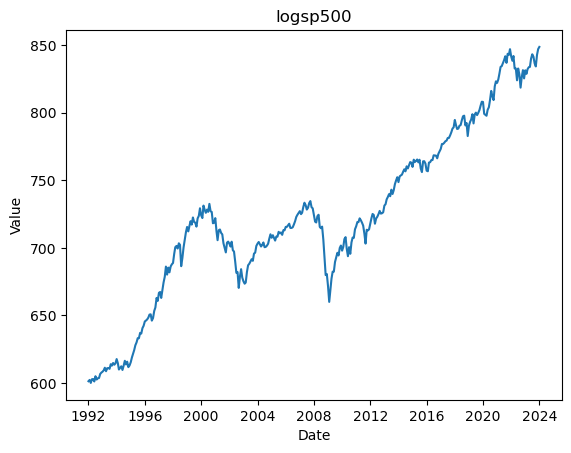

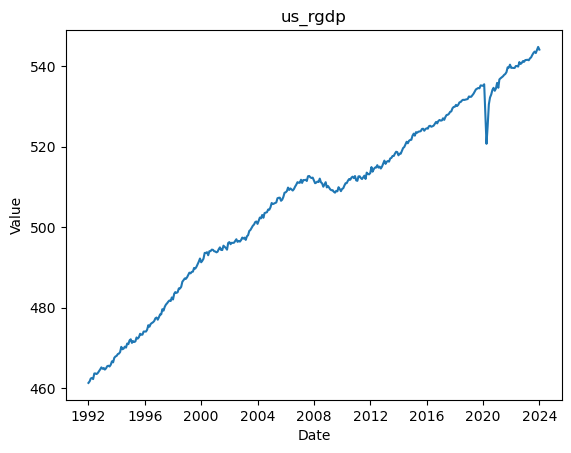

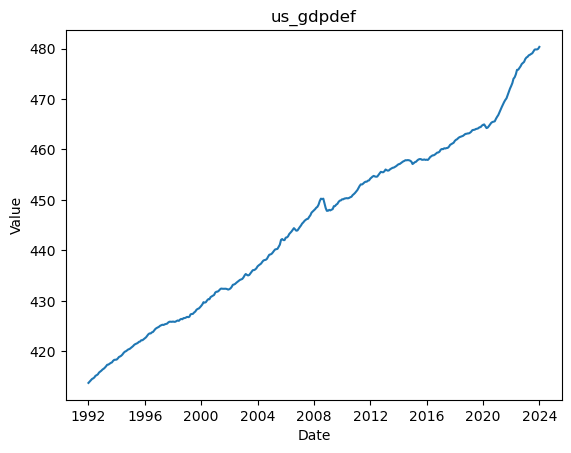

In [430]:
plt.figure(figsize=(12, 6))

for column in ['gs1', 'logsp500', 'us_rgdp', 'us_gdpdef']:
    plt.figure()
    plt.plot(VARdata[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel('Value')
plt.show()


## Lag order Selection

In [9]:
VARpython = VARdata.copy()
# Apply differencing
for col in ['logsp500', 'us_rgdp', 'us_gdpdef']:
    VARpython[col] = VARpython[col].diff()
    
#VARdata['gs1'] = VARdata['gs1'].diff()
    
VARpython.dropna(inplace=True)

In [10]:
#Put all the stationarity test results in a table with the adf statistic and p-values
columns_to_check_ = ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']

adf_results = []
for col in columns_to_check_:
    result = adfuller(VARpython[col])
    adf_results.append([col, result[0], result[1]])
adf_results = pd.DataFrame(adf_results, columns=['Variable', 'ADF Statistic', 'p-value'])

# export as an xlsx file
adf_results.to_excel('data/adf_results.xlsx')

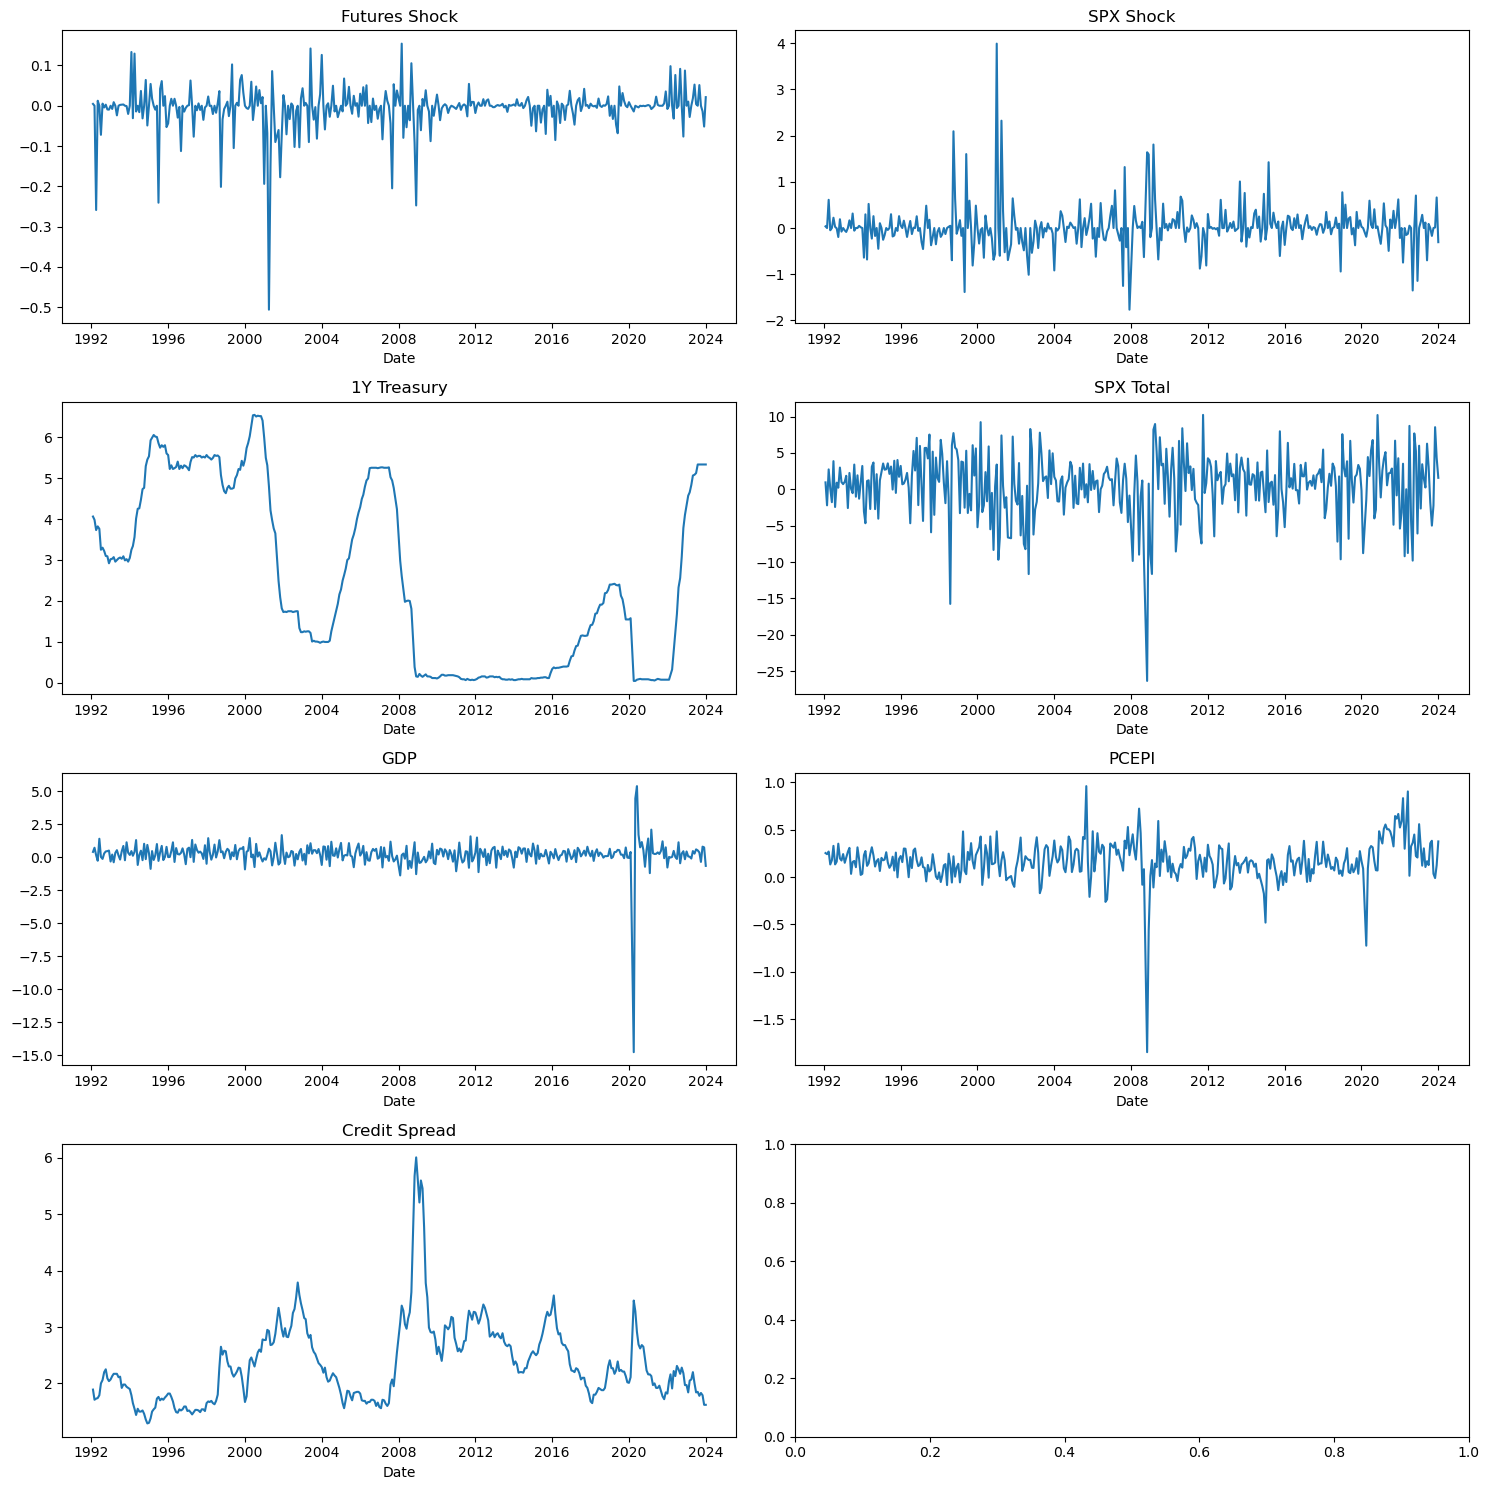

In [11]:
#Plot 'M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total'
fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for i, col in enumerate(columns_to_check_):
    labels = ['Futures Shock', 'SPX Shock', '1Y Treasury', 'SPX Total', 'GDP', 'PCEPI', 'Credit Spread', 'Unemployment']
    label = labels[i]
    ax = axs[i//2, i%2]
    ax.plot(VARpython[col])
    ax.set_title(label)
    # set x axis to the index
    ax.set_xlabel('Date')

plt.tight_layout()

In [1]:
# Initialize and fit the VAR model
model_var = VAR(VARpython[['gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']], exog=VARpython[['ff4_hf', 'sp500_hf'] ])
lag_selection = model_var.select_order(maxlags=24)
optimal_lags = lag_selection

NameError: name 'VAR' is not defined

Lag order of 12 in line with the Prior literature.

Original paper (Marek Jarociński and Peter Karadi (2018)) and Silvia Miranda-Agrippino and Giovanni Ricco (2021) both use the same lag order

We see from the table below that the ICs are not in agreement, we could argue that a lag order of 1 is valid. Since we do not need to impose a penalty for higher orders, AIC is the chosen criterion

In [14]:
# Fit the VAR model with the chosen lag length
var_results = model_var.fit(12)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, May, 2024
Time:                     18:55:37
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -4.67926
Nobs:                     368.000    HQIC:                  -6.69547
Log likelihood:          -819.339    FPE:                0.000332965
AIC:                     -8.02450    Det(Omega_mle):     0.000151096
--------------------------------------------------------------------
Results for equation gs1
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.183623         0.096793            1.897           0.058
ff4_hf                0.654885         0.244755            2.676           0.007
sp500_hf              0.007470         0.025719            0.2

At this point, we run the SVAR with exogeneity conditions and sign restrictions using the original code from the paper found at: replication_file/work_matlab/main1.m

All the replication files are in MATLAB which requires a paid license.

We adapted the script in the file for our needs, namely we only use the sign restriction method and we the Gibbs Sampler to predict surprises in period where There is no FOMC meeting. However, we put in much less draws than the original paper in order to make it less computationally intensive.

all that is needed is to change the directories in the script and run the matlab code.

In [15]:
#open data/residuals.csv
residuals = pd.read_csv('data/median_resid.csv')
residuals.columns = ['ff4_hf', 'sp500_hf', 'gs1', 'logsp500', 'us_rgdp', 'us_gdpdef', 'ebpnew']
residuals.set_index(VARdata.index[:len(residuals)], inplace=True)
residuals

,ff4_hf,sp500_hf,gs1,logsp500,us_rgdp,us_gdpdef,ebpnew
Date,,,,,,,
1992-01-01,-0.002069,0.031891,-0.017983,1.00160,-0.232300,-0.018992,0.040590
1992-02-01,-0.013308,-0.038498,-0.001158,1.87060,-0.854100,0.055116,0.033375
1992-03-01,-0.009972,0.030840,-0.167080,-2.44510,-0.341610,0.112000,0.009590
1992-04-01,-0.003114,0.025542,-0.027725,1.59080,-0.010772,0.139240,-0.041869
1992-05-01,-0.005421,-0.081593,-0.030167,-0.38549,-0.432390,-0.157280,-0.046729
...,...,...,...,...,...,...,...
2022-08-01,0.051324,-0.170530,0.047814,-6.99560,0.396970,0.165550,-0.110020
2022-09-01,0.000000,0.000000,0.009525,-5.21750,0.141520,-0.136460,-0.074650
2022-10-01,-0.013891,0.012590,0.045891,5.93160,0.908650,-0.102970,-0.177290


In [16]:

# Assuming `residuals` is your array of residuals
constant = np.ones((len(residuals), 1))  # Column of ones for the constant term
exog_het = np.hstack((constant, residuals.loc[:, ['ff4_hf', 'sp500_hf']].values))

# Assuming `residuals` is your DataFrame of residuals
exog_het = pd.DataFrame({
    'constant': np.ones(len(residuals)),
    'ff4_hf': residuals['ff4_hf'],  # Assuming 'ff4_hf' is a column in residuals
    'sp500_hf': residuals['sp500_hf']  # Assuming 'sp500_hf' is a column in residuals
})

In [20]:
import statsmodels.api as sm
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# Assuming `residuals` is your 3D array of residuals, where the first dimension is for equations
num_equations = residuals.iloc[:,2:].shape[1]
het_results = []
shapiro_results = []
dw_results = []

for i in range(1, num_equations+1):
    residuals_array = residuals.values
    equation_residuals = residuals_array[:, i-1:i]
    
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(equation_residuals, exog_het=exog_het, robust=True)
    het_results.append((lm, lm_pvalue, fvalue, f_pvalue))
    
    # Shapiro-Wilk test
    shapiro_test_stat, shapiro_p_value = shapiro(equation_residuals)
    shapiro_results.append((shapiro_test_stat, shapiro_p_value))

    # Durbin-Watson test
    dw_test_stat = durbin_watson(equation_residuals)
    dw_results.append(dw_test_stat)



In [21]:
het_results_df = pd.DataFrame(het_results, columns=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value'])
het_results_df.index = residuals.columns[2:]

for i, col in enumerate(residuals.columns[2:]):
    if (het_results_df['LM p-value'].loc[col] < 0.05):
        print(f'Heteroskedasticity detected in {col}')

het_results_df

Heteroskedasticity detected in gs1
Heteroskedasticity detected in logsp500


,LM Statistic,LM p-value,F Statistic,F p-value
gs1,146.498354,1.542718e-32,120.703165,5.808552e-41
logsp500,107.010180,5.794749e-24,74.828045,5.842170e-28
us_rgdp,5.489955,6.424973e-02,2.763832,6.436967e-02
us_gdpdef,3.860867,1.450853e-01,1.934997,1.459034e-01
ebpnew,0.462117,7.936932e-01,0.229463,7.950751e-01


In [22]:
shapiro_results_df = pd.DataFrame(shapiro_results, columns=['T-stat', 'p-value'])
shapiro_results_df.index = residuals.columns[2:]

for i, col in enumerate(residuals.columns[2:]):
    if (shapiro_results_df['p-value'].loc[col] < 0.05):
        print(f'Non-normality detected in {col}')
        
shapiro_results_df

Non-normality detected in gs1
Non-normality detected in logsp500
Non-normality detected in us_rgdp
Non-normality detected in us_gdpdef
Non-normality detected in ebpnew


,T-stat,p-value
gs1,0.702432,5.019550e-25
logsp500,0.768689,2.044219e-22
us_rgdp,0.683747,1.113374e-25
us_gdpdef,0.962934,4.942905e-08
ebpnew,0.445589,3.937205e-32


In [23]:
dw_results_df = pd.DataFrame(dw_results, columns=['Durbin-Watson Statistic'])
dw_results_df.index = residuals.columns[2:]

for i, col in enumerate(residuals.columns[2:]):
    dw_stat = dw_results_df['Durbin-Watson Statistic'].loc[col]
    if dw_stat < 1.5:
        print(f'Positive autocorrelation detected in {col}')
    elif dw_stat > 2.5:
        print(f'Negative autocorrelation detected in {col}')
    else:
        print(f'No autocorrelation detected in {col}')

dw_results_df

No autocorrelation detected in gs1
No autocorrelation detected in logsp500
No autocorrelation detected in us_rgdp
No autocorrelation detected in us_gdpdef
No autocorrelation detected in ebpnew


,Durbin-Watson Statistic
gs1,1.863635
logsp500,2.155625
us_rgdp,1.818884
us_gdpdef,2.003928
ebpnew,2.080876


In [24]:
#Store all the test diagnostics results into an xlsx file
with pd.ExcelWriter('data/diagnostics_results.xlsx') as writer:
    het_results_df.to_excel(writer, sheet_name='het_results')
    shapiro_results_df.to_excel(writer, sheet_name='shapiro_results')
    dw_results_df.to_excel(writer, sheet_name='dw_results')

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


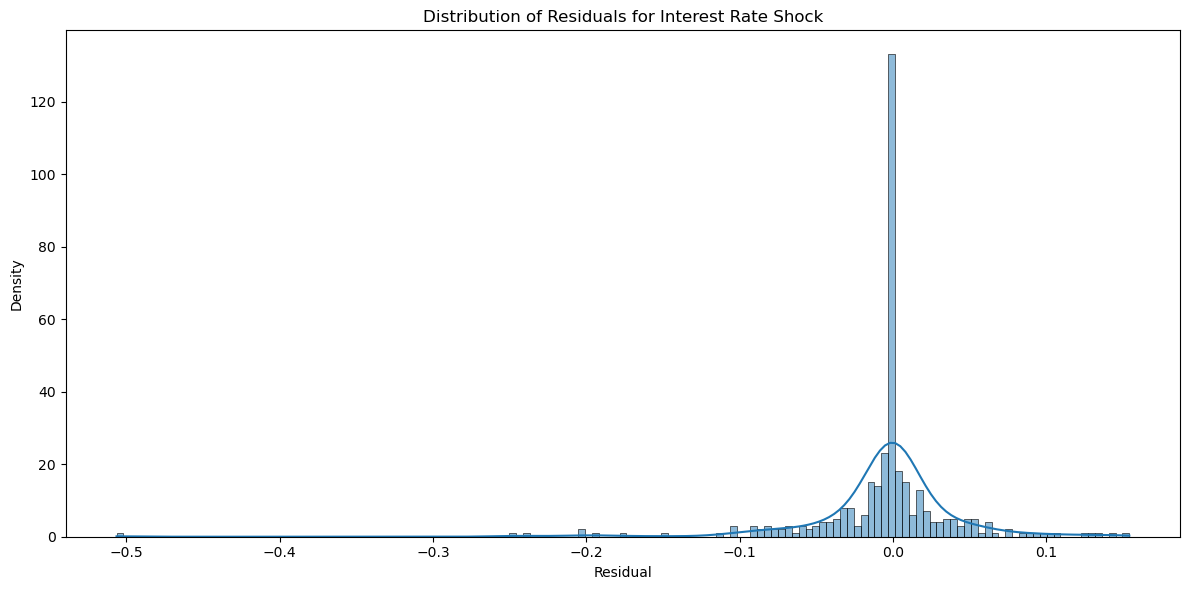

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


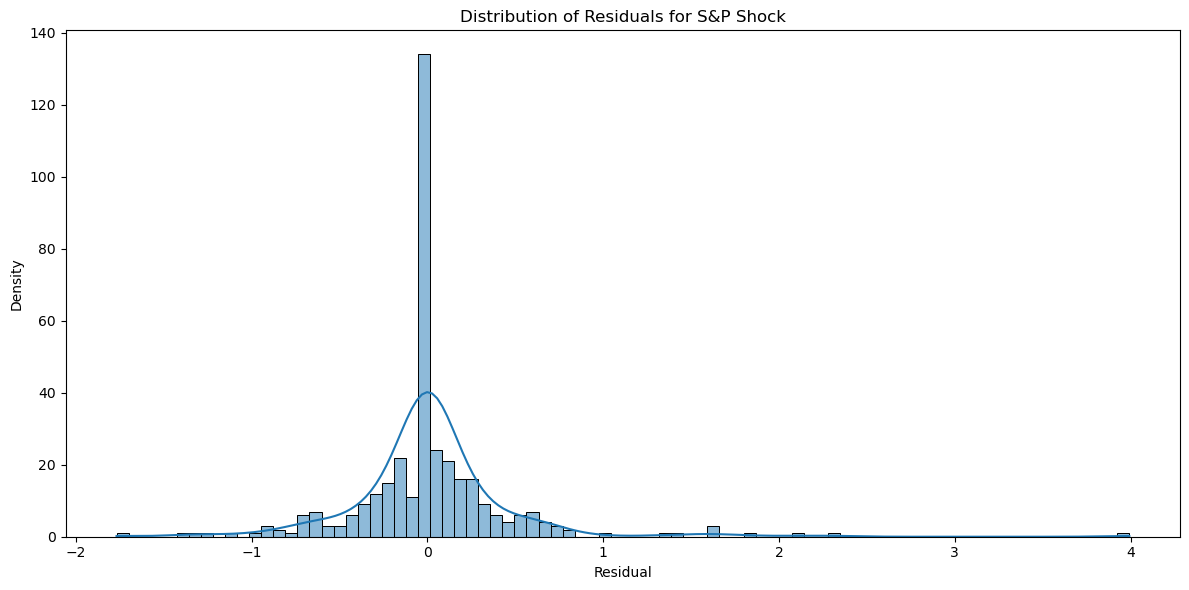

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


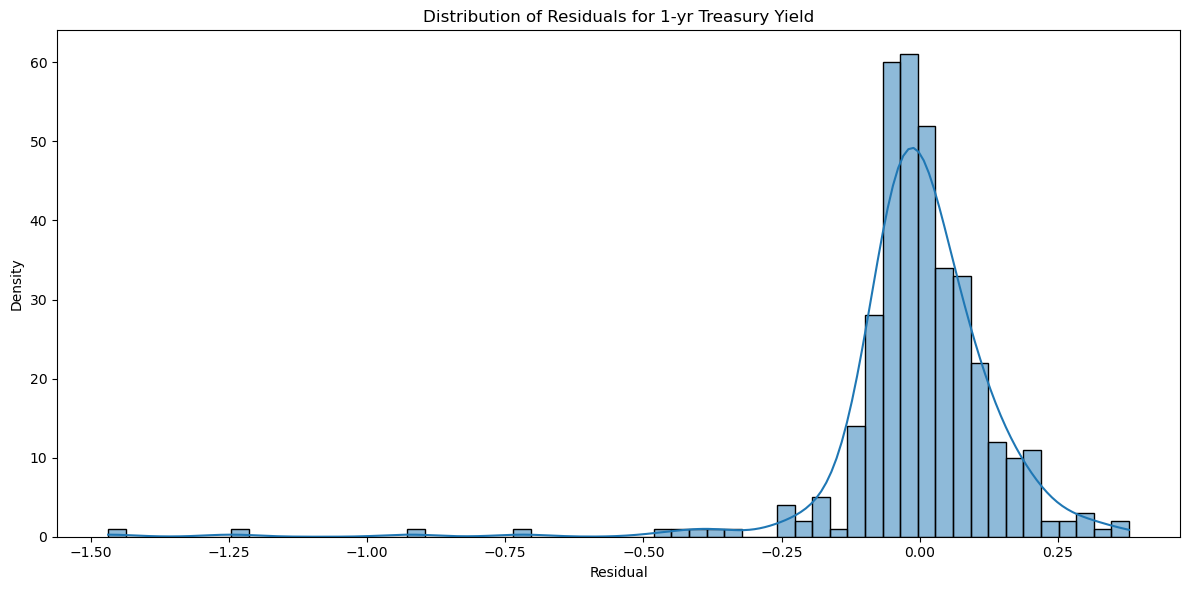

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


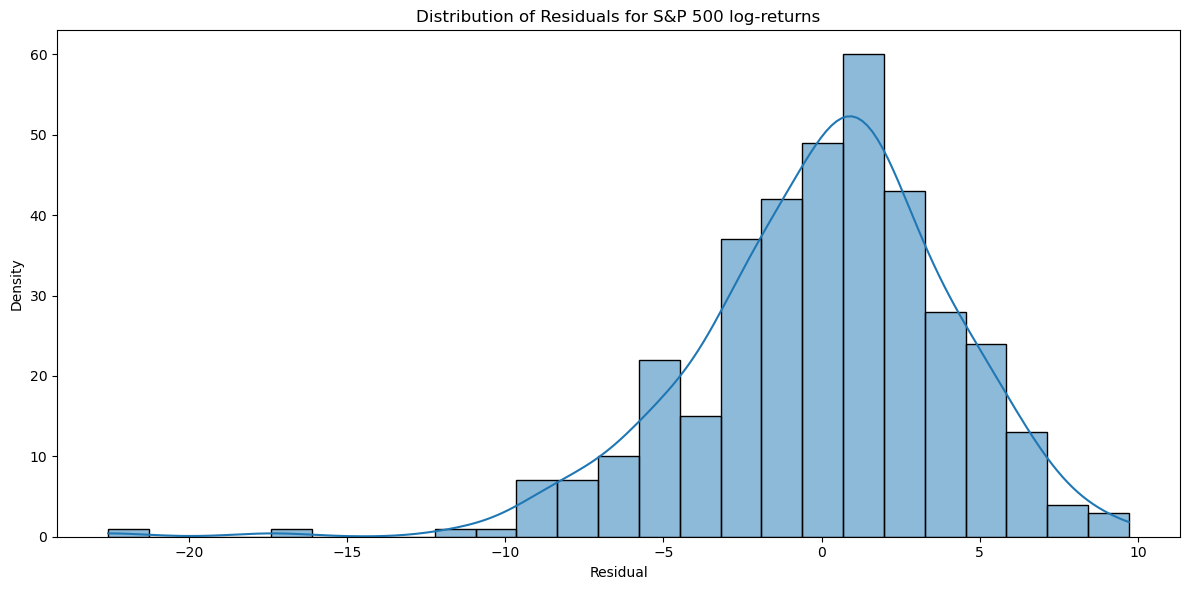

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


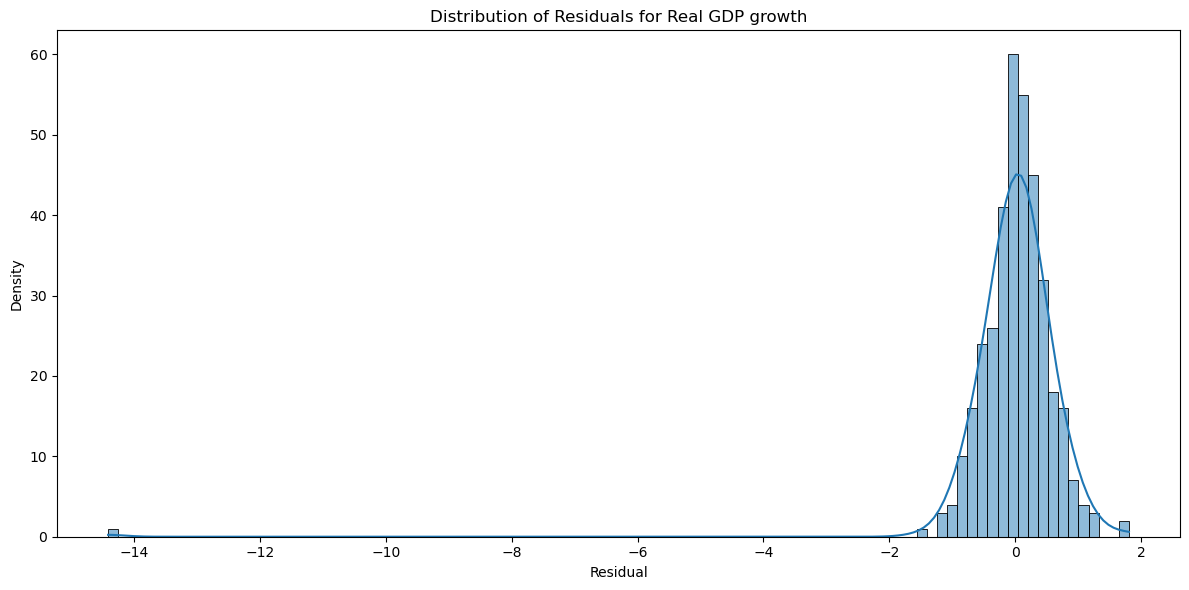

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


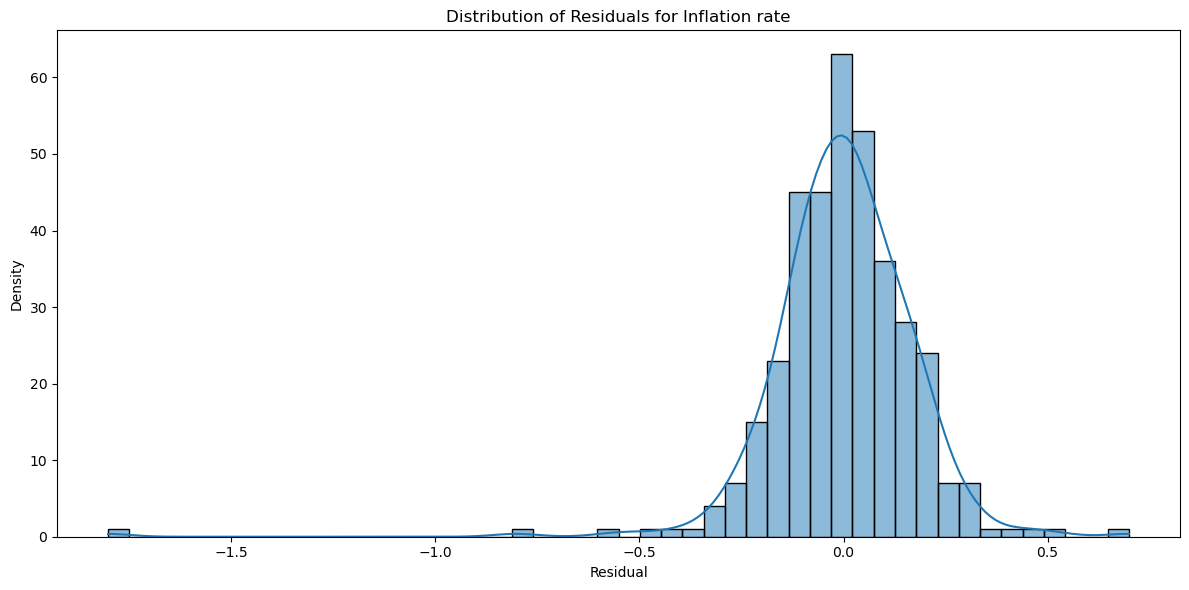

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


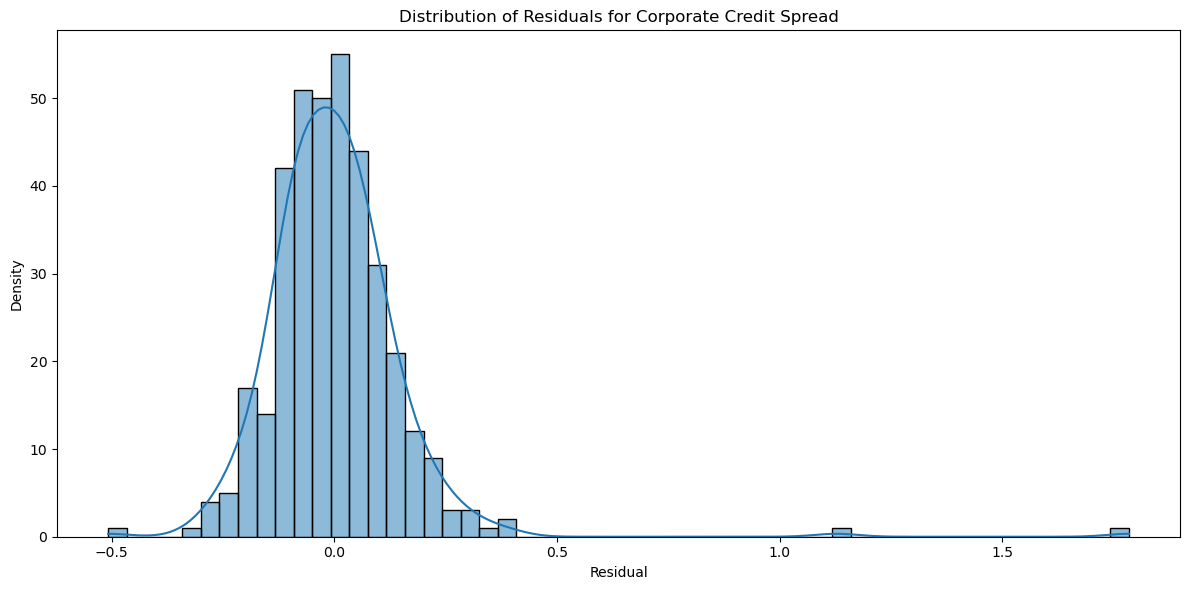

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, col in enumerate(residuals.columns):
    pretty_name = ['Interest Rate Shock', 'S&P Shock', '1-yr Treasury Yield', 'S&P 500 log-returns', 'Real GDP growth', 'Inflation rate', 'Corporate Credit Spread']
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(residuals[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of Residuals for {pretty_name[i]}')
    ax.set_xlabel('Residual')
    ax.set_ylabel('Density')
    plt.tight_layout()
    plt.show()